## This notebook comprises a data analysis of rental listings data, in which we try to estimate rental prices at the city level for SF Bay Area cities. 

### NB: This notebook is essentially a demo of the data_analysis.py script, and to run this script or notebook, we assume we have performed the 1st 2 phases of this webcrawler project: ie, we have already done the following: 1.) Used the webcrawler at least once; & 2.) We have cleaned and wrangled the scraped data, and we have used the CSV (to Pandas' DataFrame) to SQL data pipeline so that we have the data stored into a SQL Server table. This way, we can quikly query (relatively) cleaned data from the SQL Server table.

### The steps of this data analysis phase of the project are as follows: 

### A.) We start by importing the data from the SQL rental table, but ensure that price > $1. B.) We then ensure the variables are of the correct data type, and we will remove any columns that are irrelevant to an empirical analysis of rental prices. C.) We then perform some data exploration, such as examining the distribution of several key variables, such as rental price (the outcome variable), number of bedrooms, and square feet. D.) We wrangle, normalize, and prepare the data by using multiple (k-fold) cross validation to split the overall dataset into several segments, each of which will be used to train several different regression models. E.) Finally, we implement The notebook is essentially a demo of the data_analysis.py script:various regression models, including comparing the predictive accuracy of the models. Using the most accurate models, we will make predictions of city-level rental prices.  

In [1]:
# imports:
# file processing
import os
import glob

# data analysis libraries & SQL libraries
import numpy as np
import pandas as pd
# SQL ODBC for API connection between Python & SQL Server
import pyodbc
import sqlalchemy as sa

# data visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import json

# statistical and ML modeling and hypothesis testing libraries
from sklearn.model_selection import KFold   # k-fold cross validation
from sklearn.model_selection import train_test_split  # split datasets into training & test datasets
from sklearn import linear_model  # OLS 
from sklearn import ensemble  # ensemble module contains the GradientBoostingRegressor class, which is used to estimate Gradient-boosted regression models

from sklearn.metrics import mean_squared_error  # calculate MSE to estimate accuracy of regression models 


## A.) Import data from SQL table, but ensure square feet data is available (ie, is not null) and price > $1: 

In [104]:
# import data from rental table
class SQL_Database():
    def __init__(self, sql_config_path):

        with open(sql_config_path, 'r') as fh:
            config = json.load(fh)

        self.driver = config['driver']
        self.server = config['server']
        self.database = config['database']
        self.username = config['username']
        self.password = config['password']
        print(f"Name of connected database:\n{self.database}")


    def import_SQL_to_df(self, sql_query):
        """Import dataset by using SQL query and Pandas' read_sql() method"""
        conn = pyodbc.connect(
            f'DRIVER={self.driver};'
            f'SERVER={self.server};'
            f'DATABASE={self.database};'
            f'UID={self.username};'
            f'PWD={self.password};'
            'Trusted_Connection=yes;'
        )

        # establish connection to SQL Server database, by passing in the database name, etc., using a with statement so it will automatically close the connection & cursor once the with statement has completed execution:
        # initialize cursor so we can execute SQL code
        cursor = conn.cursor() 

        # query to select all records in which a.) sqft data exists (ie, NOT NULL) and b.) where price > $1, since such a price is essentially impossible and likely a typo from the original scraped rental listing
        # specify SQL query
        sql = sql_query 

        # export SQL query results to Pandas' DataFrame
        df = pd.read_sql(sql,conn)  # export results of SQL query to Pandas' DataFrame

        cursor.close()
        conn.close()
        return df


## import data with no sqft nu+lls and price >$1, via SQL query to Pandas' df
# specify path to json file containing SQL configuration/username data
sql_config_path = "D:\\Coding and Code projects\\Python\\craigslist_data_proj\\CraigslistWebScraper\\SQL_config\\config.json" 

SQL_db = SQL_Database(sql_config_path)  # NB: be sure to pass in path to the json SQL configuration file so we can load in the needed username, password, and configuration data to be able to access the SQL database

# specify query for data selection
query = """SELECT * FROM rental WHERE price > 100 AND region = 'sfbay';"""
# import data to DataFrame via SQL query and Pandas' read_sql() method
df = SQL_db.import_SQL_to_df(query)
df.info() # sanity check

Name of connected database:
craigslist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15142 entries, 0 to 15141
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   listing_id               15142 non-null  int64         
 1   sqft                     15142 non-null  int64         
 2   city                     15142 non-null  object        
 3   price                    15142 non-null  int64         
 4   bedrooms                 15142 non-null  int64         
 5   bathrooms                15142 non-null  float64       
 6   attr_vars                15142 non-null  object        
 7   date_of_webcrawler       15142 non-null  datetime64[ns]
 8   kitchen                  15142 non-null  int64         
 9   date_posted              15142 non-null  datetime64[ns]
 10  region                   15142 non-null  object        
 11  sub_region               15142 non-null  object       

## B.) Ensure each column is of the correct data type, and add datetime cols such as a week indicator for week-over-week time fixed effects:

In [4]:
## Data cleaning and feature engineering--ensure columns are of correct data type:
print(f"Data types of each column from queried SQL rental table:\n{df.dtypes}")

Data types of each column from queried SQL rental table:
listing_id                          int64
sqft                                int64
city                               object
price                               int64
bedrooms                            int64
bathrooms                         float64
attr_vars                          object
date_of_webcrawler         datetime64[ns]
kitchen                             int64
date_posted                datetime64[ns]
region                             object
sub_region                         object
cats_OK                             int64
dogs_OK                             int64
wheelchair_accessible               int64
laundry_in_bldg                     int64
no_laundry                          int64
washer_and_dryer                    int64
washer_and_dryer_hookup             int64
laundry_on_site                     int64
full_kitchen                        int64
dishwasher                          int64
refrigerator       

## B2) Next, let's add some additional columns to be used for time series and time fixed effects:

### a) Namely: add a day of week col to specify the names of weekdays for each given rental listing's date_posted

### b) Also, create a week over week indicator--ie, to specify the week

### c) Similarly, a month indicator

### d) Finally, a year indicator

In [144]:
def create_weekday_name_col(df, datetime_col):
    return df[datetime_col].dt.day_name()

# a) day of week (ie, Sunday, Monday, etc.)
df['day_of_week'] = create_weekday_name_col(df, 'date_posted')

def create_week_datetime_col(df, datetime_col):
    return df[datetime_col].dt.week


# b) week over week indicator
df['week'] = create_week_datetime_col(df, 'date_posted')

def create_month_datetime_col(df, datetime_col):
    return df[datetime_col].dt.month


df['month'] = create_month_datetime_col(df, 'date_posted')


def create_year_datetime_col(df, datetime_col):
    return df[datetime_col].dt.year

df['year'] = create_year_datetime_col(df, 'date_posted')


df[['day_of_week', 'week', 'month' , 'year', 'date_posted']] # sanity check

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,day_of_week,week,month,year,date_posted
975,Wednesday,44,11,2021,2021-11-03 17:15:00
1135,Thursday,43,10,2021,2021-10-28 18:26:00
1136,Thursday,43,10,2021,2021-10-28 18:37:00
1137,Thursday,43,10,2021,2021-10-28 18:54:00
1138,Thursday,43,10,2021,2021-10-28 18:56:00
...,...,...,...,...,...
15137,Sunday,7,2,2022,2022-02-20 14:09:00
15138,Sunday,7,2,2022,2022-02-20 16:44:00
15139,Monday,8,2,2022,2022-02-21 07:27:00
15140,Monday,8,2,2022,2022-02-21 14:39:00


In [5]:
df['date_posted'].dt.week, df['date_posted'].dt.year

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


(0        36
 1        36
 2        36
 3        36
 4        36
          ..
 15137     7
 15138     7
 15139     8
 15140     8
 15141     8
 Name: date_posted, Length: 15142, dtype: int64,
 0        2021
 1        2021
 2        2021
 3        2021
 4        2021
          ... 
 15137    2022
 15138    2022
 15139    2022
 15140    2022
 15141    2022
 Name: date_posted, Length: 15142, dtype: int64)

## B3) NB: The full panel dataset is imbalanced with respect to sub_regions--ie, not all sub_regions have data going back as far as others.

### Thus, we need to identify what were the *first* rental listing dates per sub_region. 

### Let's do a SQL query to determine these MIN dates:

In [106]:
# specify path to json file containing SQL configuration/username data
sql_config_path = "D:\\Coding and Code projects\\Python\\craigslist_data_proj\\CraigslistWebScraper\\SQL_config\\config.json" 

SQL_db = SQL_Database(sql_config_path)  # NB: be sure to pass in path to the json SQL configuration file so we can load in the needed username, password, and configuration data to be able to access the SQL database

# determine the first date of rental listings per sub_region, and order by DESC to show the most recent such date. Select only SF Bay data:
sql_query = """SELECT sub_region, MIN(date_posted) AS first_rental_listing_date FROM rental WHERE region = 'sfbay' GROUP BY sub_region ORDER BY MIN(date_posted) DESC;"""


# import data to DataFrame via SQL query and Pandas' read_sql() method
min_date_per_subregion = SQL_db.import_SQL_to_df(sql_query)
min_date_per_subregion

Name of connected database:
craigslist


,sub_region,first_rental_listing_date
0,sfc,2021-10-28 18:00:00
1,scz,2021-10-12 14:38:00
2,sby,2021-10-09 17:36:00
3,eby,2021-09-29 08:15:00
4,nby,2021-09-25 21:28:00
5,pen,2021-09-06 21:54:00


In [11]:
min_date_per_subregion.first_rental_listing_date.head(1)[0]

Timestamp('2021-10-28 18:00:00')

## B3 b) Next, let's filter the dataset to date > the most recent MIN() date found by sub_region (ie, filter df dataset by the *last* min date per sub_region)

In [107]:
# filter dataset by *last* min date per sub_region
def filter_data_by_min_subregion_date(df, min_subregion_query_results):
    # parse the most recent MIN() date by sub_region--ie, given query has been ordered by DESC order, get the first element of the first_rental_listing_date col 
    most_recent_MIN_subregion_date = min_subregion_query_results.first_rental_listing_date.head(1)[0]   # get the most recent of the oldest dates per subregion  
    return df.loc[df.date_posted > most_recent_MIN_subregion_date]

# apply the datetime filter
df = filter_data_by_min_subregion_date(df, min_date_per_subregion)

# sanity check on the oldest date after applying the filter
df.sort_values(by=['date_posted'])['date_posted'].head()

1135   2021-10-28 18:26:00
1136   2021-10-28 18:37:00
1137   2021-10-28 18:54:00
1138   2021-10-28 18:56:00
1139   2021-10-28 19:11:00
Name: date_posted, dtype: datetime64[ns]

## C.) Data exploration and visualizations


### Let's start by examining the distributions of several key variables such as rental price, # of bedrooms, # of bathrooms, and sqft:





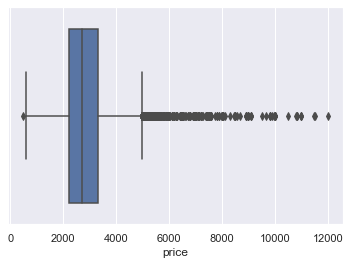

In [11]:
## boxplots of important variables
def boxplot(df, col, hue_option_col):
    """Implement boxplot of given col from given dataset (df)"""
    sns.set_theme(style="darkgrid")
    ax = sns.boxplot(x=df[col], hue=hue_option_col)
    

## distribution of price (overall dataset) boxplot
boxplot(df, 'price', None) # distribution of price overall


### At first glance, notice that the distribution of price is highly positively skewed, with the upper quartile of rental prices having values that exceed the median value of price (roughly $2,500) very substantially.

### Next, let's examine the data at a somewhat finer granmularity: examine a boxplot of price, but differentiate the price distributions by the number of bedrooms:

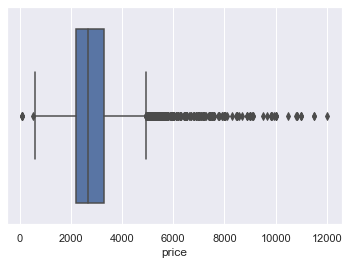

In [6]:

## distribution of price by number of bedrooms boxplot
boxplot(df, 'price', df['bedrooms']) # distribution of price by number of bedrooms

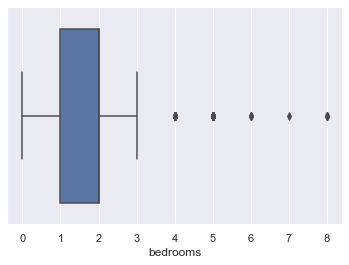

In [7]:
## distribution of number of bedrooms boxplot
boxplot(df, 'bedrooms', None) # distribution of  number of bedrooms

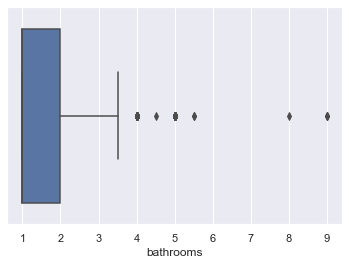

In [8]:
## distribution of number of bathrooms boxplot
boxplot(df, 'bathrooms', None) # distribution of  number of bathrooms

### Examine distribution of data by whether a rental is furnished:

In [25]:
# distribution of data by is furnished: 
df.is_furnished.value_counts()

0    10271
1      633
Name: is_furnished, dtype: int64

## Examine distribution of bedrooms and bathrooms (respectively) with respect to price

### Create seaborn boxplot function comparing a variable to a y-axis variable, and be able to specify a hue (such as SF Bay subregion) 

### Distribution of price by # of bedrooms (overall)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

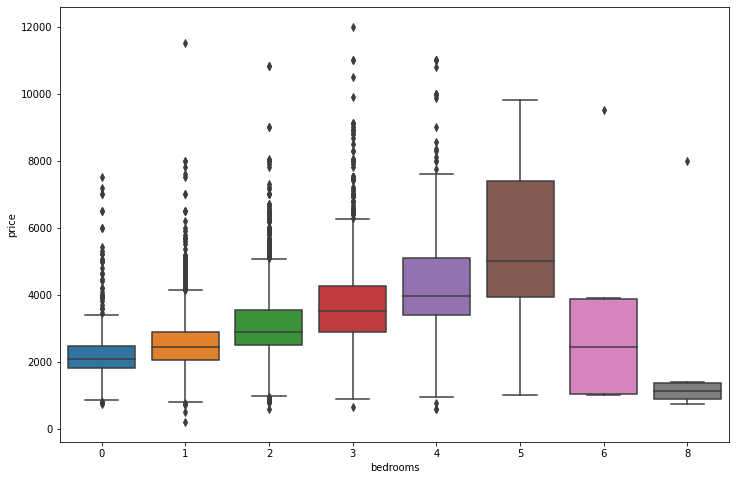

In [14]:
def boxplot_with_y_var_and_hue(df, x_axis_var, y_axis_var, hue_option):
    plt.figure(figsize=(12,8))
    return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var, hue=hue_option)


# prices distribution by # of bedrooms (overall) boxplot
boxplot_with_y_var_and_hue(df, "bedrooms", "price", None)

### Boxplot analysis:

### Notice that the overall distributions of price tends to increase as the number of bedrooms also increases, but not entirely consistently. 

### For example, this apparent positive correlation begins to fall apart and oddly beings to show a negative correlation between the number of bedrooms and average perices as the number of bedrooms increases above 5 (namely: 6 or 8). In other words, the positive correlation between the number of bedrooms and the median rental price only holds up to rental listings with up to 5 bedrooms. *However,* it's possible that these listings were posted with an *incorrect* number of bedrooms, which would indicate this supposed negative correlation for 6 & 8 bedrooms  woth respect to rental price is simply spurious correlation due to measurement

### A few other notable things to consider is that at a very low number of bedrooms, particularly studios (0 bedrooms) vs 1 bedroom listings and even 2 bedrooms (to a lesser extent), the distribution of prices only increases somewhat, with sharper increases when the number of bedrooms increases from 3 to 4 and especially from 4 to 5. 

### Distribution of price by # of bedrooms and subregion (hue)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

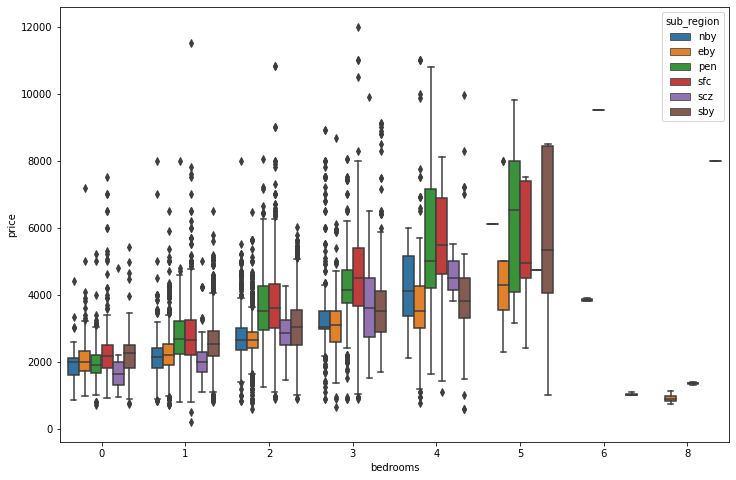

In [21]:
#  boxplot of # of bedrooms by pruce and sub_region (hue): 
boxplot_with_y_var_and_hue(df, "bedrooms", "price", "sub_region")

## Analysis of plot

### Notice that when we take subregion into account, it's obvious there are at notable (and quite possibly statistically signficant) differences in rental prices among each subregion, even when comparing rental listings that have the same number of bedrooms.

### For most numbers of bedrooms, East Bay and especially Santa Cruz rental listings tend to be somewhat less expensive than the other Bay Area subregions. On the other side of this spectrum, San Francisco and Peninsula listings tend to be the most expensive rental listings. Also, studios 2 bedroom and especially 1 bedroom rental listings, Peninsula listings are nearly the same on average as that of SF listings. However, for rental listings with a large number of bedrooms--namely, 5 bedrooms--Peninsula listings actually are the most expensive on average by a large margin (perhaps driven by cities that are known to have many large and especially expensive properties, such as Palo Alto, Atherton, and Woodside).

### In addition, the number of rental listings that have either 6 or 8 bedrooms is very small. As mentioned above, it's possible that some (or all) of these listings were posted with an incorrect number of bedrooms. This would explain the negative correlation as being spurious, and thus not contradict basic economic theory. 

### As a result, let's remove listings (supposedly) with 6 or 8 bedrooms that have highly suspiciously low rental prices (e.g., < $3,500).

In [79]:
# remove listings that are very likely posted with incorrect number of bedrooms
def delete_listings_with_incorrect_bedroom_and_price_vals(df):
    """Remove apartment property type that have suspiciously low rental prices and an absurdly high number of bedrooms: namely--6 or more bedrooms."""
    # remove listings that are of apt type, have 6+ bedrooms, and have rental price < $3,500  
    return df.loc[~((df.bedrooms>5) & (df.price < 3500))]

#filter data
df = delete_listings_with_incorrect_bedroom_and_price_vals(df)
# sanity check
df.bedrooms.value_counts()  # NB: there should be fewer listings with > 5 bedrooms  

1    5852
2    5260
3    1457
0    1054
4     296
5      58
6       3
8       1
Name: bedrooms, dtype: int64


### Next, let's examine distribution of price by number of bathrooms:




<AxesSubplot:xlabel='bathrooms', ylabel='price'>

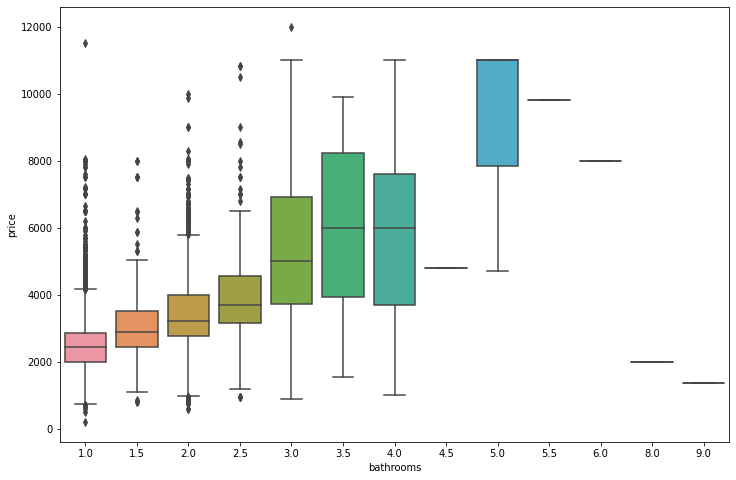

In [82]:
# bathrooms wrt prices and subregion boxplot
boxplot_with_y_var_and_hue(df, "bathrooms", "price", None)

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

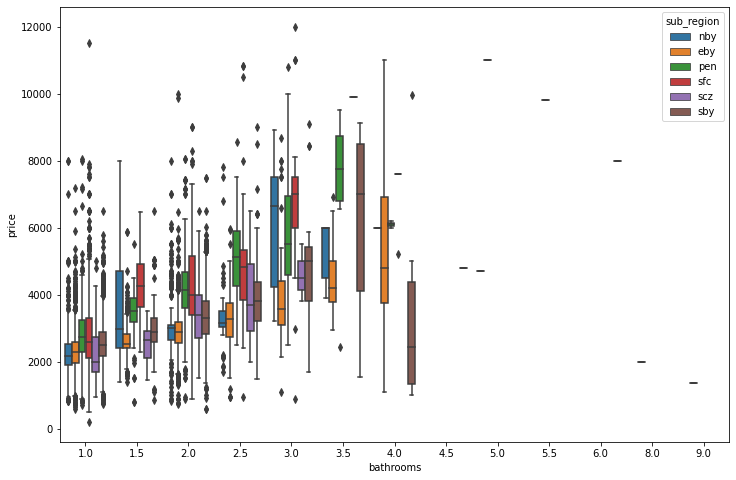

In [81]:
# bathrooms wrt prices and subregion boxplot
boxplot_with_y_var_and_hue(df, "bathrooms", "price", "sub_region")

In [ ]:
## Data cleaning--cont'd:

## Dealing with groups of indicator variables that are *mutually exclusive* to each other:

### For the groups of indicator variables that are supposed to be *mutually exclusive* to each other--e.g., the housing type indicators (ie, apt, duplex, etc)--we need to remove records that violate this assumption of being mutually exclusive before running regression models since this would bias the coefficients of each such set of dummy variables!

### a) First, we need to identify *each rental listing* (ie, row from df) in which the given listing shows a value of 1 for *more than 1* of the indicator variables from a set of indicator variables that actually are mutually exclusive.

### Remove any listings from the dataset in which there's a value of 1 for *more than one* of the indicator variables *within* one of these mutually exclusive indicator variables:

### 1) Let's start with the housing/property type indicator variables (ie, apt, single_fam, etc.):

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13440 entries, 975 to 15141
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     13440 non-null  object        
 1   price                    13440 non-null  int64         
 2   bedrooms                 13440 non-null  int64         
 3   bathrooms                13440 non-null  float64       
 4   kitchen                  13440 non-null  int64         
 5   date_posted              13440 non-null  datetime64[ns]
 6   region                   13440 non-null  object        
 7   sub_region               13440 non-null  object        
 8   cats_OK                  13440 non-null  int64         
 9   wheelchair_accessible    13440 non-null  int64         
 10  laundry_in_bldg          13440 non-null  int64         
 11  no_laundry               13440 non-null  int64         
 12  washer_and_dryer_hookup  13440

In [6]:
# identify whether any sets of indicator variables are perfectly collinear
def identify_perfect_collinearity(df, indicator_var_group_col_names:list, sum_of_indicator_groups_colname):
    """Using a list of all columns within a group of idicator variables, take the .sum() along the rows (ie, axis=1) identify if any rows have a 1 in *more than 1* of the cols by seeing whether the .sum() of the indicator cols along the rows (ie, axis=1) is greater than 1. 
    If this is the case, then the given group of indicator vars is *not* pefectly collinear (even though they theoretically should be)!"""
    # compute sum of given group of indicator var cols along rows (ie, axis=1), and add this sum as new col:
    df[sum_of_indicator_groups_colname] = df[indicator_var_group_col_names].sum(axis=1)  # take sum of group of indicator var cols 

    # see whether any rows (ie, rental listings) have a sum >1 among the group of indicator cols. If so, then *remove* these given rows (rental listings).
    row_filter = df[df[sum_of_indicator_groups_colname] > 1]  # specify filter criteria
    # sanity check
    print(f"The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:\n{row_filter}")
    # remove these problematic rows from dataset, by applying the negation of the filter (ie, with sum <= 1):
    df = df[df[sum_of_indicator_groups_colname] <= 1]
    # remove sum_of_indicator_groups_colname since it's no longer needed
    df = df.drop(columns=[sum_of_indicator_groups_colname])
    return df


# property/home indicator var cols group
housing_type_indicators = ['apt', 'in_law_apt', 'condo', 'townhouse', 'cottage_or_cabin', 'single_fam', 'duplex', 'flat', 'land']


df = identify_perfect_collinearity(df, housing_type_indicators, 'housing_type_row_sum')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
      listing_id   sqft          city  price  bedrooms  bathrooms  \
1640  7405201920   5250       Fremont   2210         1        1.0   
3296  7416249344   6480    Santa Cruz   2275         1        1.0   
3546  7417853952   7430  Walnut Creek   3450         1        1.0   
4405  7421750272   9620       Concord   2710         2        2.0   
5051  7423765504   7900       Concord   2666         1        1.0   
5718  7426369024  10130        Dublin   3150         2        2.0   
6121  7427359232   8000     Palo Alto   2400         2        1.0   

                                              attr_vars date_of_webcrawler  \
1640  air conditioning\ncats are OK - purrr\ndogs ar...         2021-11-08   
3296  application fee details: $29 + tax (applicatio...         2021-12-04   
3546  air conditioning\ncats are OK - purrr\ndogs ar..

### 2) Next, let's remove records with respect to the laundry indicators:

In [7]:
# next, apply filter to laundry indicators

# specify laundry indicator var names
laundry_indicators = ['laundry_in_bldg', 'no_laundry', 'washer_and_dryer', 'washer_and_dryer_hookup', 'laundry_on_site']
 

df = identify_perfect_collinearity(df, laundry_indicators, 'laundry_ind_sum')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
       listing_id   sqft         city  price  bedrooms  bathrooms  \
1135   7400607232  11000    Fairfield   2277         3        1.0   
1267   7401122816   6000       Albany   1625         1        1.0   
1299   7402126336  12000  Mill Valley   5000         2        1.0   
1320   7402511872   4000   Occidental   2149         1        1.0   
1336   7402765312   5000      Concord   1350         1        1.0   
...           ...    ...          ...    ...       ...        ...   
15007  7448110080   4200   San Rafael   2000         0        1.0   
15093  7448306688   3850        Aptos   2000         0        1.0   
15127  7448378880   5000     San Jose   1850         1        1.0   
15133  7448508928   4100   San Rafael   2000         0        1.0   
15137  7448673792   4000   Santa Rosa   1685         1        1.0   

            

In [ ]:
### 3) Next, let's remove records with respect to flooring type indicators:

In [8]:
# flooring type indicators 
flooring_type_indicators = ['flooring_carpet',	'flooring_wood', 'flooring_tile', 'flooring_hardwood', 'flooring_other']

df = identify_perfect_collinearity(df, flooring_type_indicators, 'flooring_types')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
Empty DataFrame
Columns: [listing_id, sqft, city, price, bedrooms, bathrooms, attr_vars, date_of_webcrawler, kitchen, date_posted, region, sub_region, cats_OK, dogs_OK, wheelchair_accessible, laundry_in_bldg, no_laundry, washer_and_dryer, washer_and_dryer_hookup, laundry_on_site, full_kitchen, dishwasher, refrigerator, oven, flooring_carpet, flooring_wood, flooring_tile, flooring_hardwood, flooring_other, apt, in_law_apt, condo, townhouse, cottage_or_cabin, single_fam, duplex, flat, land, is_furnished, attached_garage, detached_garage, carport, off_street_parking, no_parking, EV_charging, air_condition, no_smoking, day_of_week, week, month, year, flooring_types]
Index: []

[0 rows x 52 columns]


### 4) Next, let's remove records with respect to the parking option indicators:

In [9]:
# parking options indicators
parking_options_indicators = ['carport', 'off_street_parking', 'no_parking']

df = identify_perfect_collinearity(df, parking_options_indicators, 'parking_ops')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
Empty DataFrame
Columns: [listing_id, sqft, city, price, bedrooms, bathrooms, attr_vars, date_of_webcrawler, kitchen, date_posted, region, sub_region, cats_OK, dogs_OK, wheelchair_accessible, laundry_in_bldg, no_laundry, washer_and_dryer, washer_and_dryer_hookup, laundry_on_site, full_kitchen, dishwasher, refrigerator, oven, flooring_carpet, flooring_wood, flooring_tile, flooring_hardwood, flooring_other, apt, in_law_apt, condo, townhouse, cottage_or_cabin, single_fam, duplex, flat, land, is_furnished, attached_garage, detached_garage, carport, off_street_parking, no_parking, EV_charging, air_condition, no_smoking, day_of_week, week, month, year, parking_ops]
Index: []

[0 rows x 52 columns]


In [125]:
df3 = pd.concat([df,df2]).drop_duplicates(keep=False)


df3

,listing_id,sqft,city,price,bedrooms,bathrooms,attr_vars,date_of_webcrawler,kitchen,date_posted,...,carport,off_street_parking,no_parking,EV_charging,air_condition,no_smoking,day_of_week,week,month,year
975,7400340992,9540,San Rafael,1600,2,1.0,cats are OK - purrr\ndogs are OK - wooof\nfloo...,2021-11-10,0,2021-11-03 17:15:00,...,0,1,0,0,0,1,Wednesday,44,11,2021
1135,7400607232,11000,Fairfield,2277,3,1.0,flooring: wood\nhouse\nno laundry on site\nno ...,2021-10-29,1,2021-10-28 18:26:00,...,0,1,0,0,0,1,Thursday,43,10,2021
1136,7400609792,9260,Fremont,2498,2,2.0,cats are OK - purrr\ndogs are OK - wooof\nfloo...,2021-10-29,1,2021-10-28 18:37:00,...,0,0,0,0,0,1,Thursday,43,10,2021
1137,7400614400,9980,Dublin,2225,2,2.0,open house dates\nfriday 2021-10-29\nsaturday ...,2021-10-29,1,2021-10-28 18:54:00,...,0,0,0,0,0,0,Thursday,43,10,2021
1138,7400614912,9980,Pittsburg,2225,2,2.0,open house dates\nfriday 2021-10-29\nsaturday ...,2021-10-29,1,2021-10-28 18:56:00,...,0,0,0,0,0,0,Thursday,43,10,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15137,7448673792,4000,Santa Rosa,1685,1,1.0,application fee details: $45 per person\ncats ...,2022-02-20,0,2022-02-20 14:09:00,...,0,1,0,0,0,0,Sunday,7,2,2022
15138,7448727040,3100,Soquel,1850,1,1.0,open house dates\nthursday 2022-02-24\nsunday ...,2022-02-21,1,2022-02-20 16:44:00,...,0,0,0,0,0,0,Sunday,7,2,2022
15139,7448891904,16780,Boulder Creek,4000,3,2.0,flooring: other\nhouse\nw/d in unit\nno smokin...,2022-02-21,1,2022-02-21 07:27:00,...,0,0,0,0,0,1,Monday,8,2,2022
15140,7449138176,5250,Santa Cruz,1800,1,1.0,cats are OK - purrr\ndogs are OK - wooof\nfurn...,2022-02-21,1,2022-02-21 14:39:00,...,0,0,0,0,0,0,Monday,8,2,2022


In [126]:
df3.columns

Index(['listing_id', 'sqft', 'city', 'price', 'bedrooms', 'bathrooms',
       'attr_vars', 'date_of_webcrawler', 'kitchen', 'date_posted', 'region',
       'sub_region', 'cats_OK', 'dogs_OK', 'wheelchair_accessible',
       'laundry_in_bldg', 'no_laundry', 'washer_and_dryer',
       'washer_and_dryer_hookup', 'laundry_on_site', 'full_kitchen',
       'dishwasher', 'refrigerator', 'oven', 'flooring_carpet',
       'flooring_wood', 'flooring_tile', 'flooring_hardwood', 'flooring_other',
       'apt', 'in_law_apt', 'condo', 'townhouse', 'cottage_or_cabin',
       'single_fam', 'duplex', 'flat', 'land', 'is_furnished',
       'attached_garage', 'detached_garage', 'carport', 'off_street_parking',
       'no_parking', 'EV_charging', 'air_condition', 'no_smoking',
       'day_of_week', 'week', 'month', 'year'],
      dtype='object')

In [131]:
len(df3.columns)

51

In [132]:
len(df.columns)

51

In [120]:
df2.land.value_counts()

0    13985
1        5
Name: land, dtype: int64

The land col was removed by the remove_cols_with_only_0s() function.


## Correlation coefficient matrix--heatmap


### Next, let's examine the correlations among the various variables, in particular, what variables are most heavily correlated with the outcome variable--namely, price (ie, rental prices):

### To do this, we can compute a correlation coefficient matrix, and then visualize positive vs negative correlations (or little to no correlation) via a heatmap with a diverging color palette: 

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


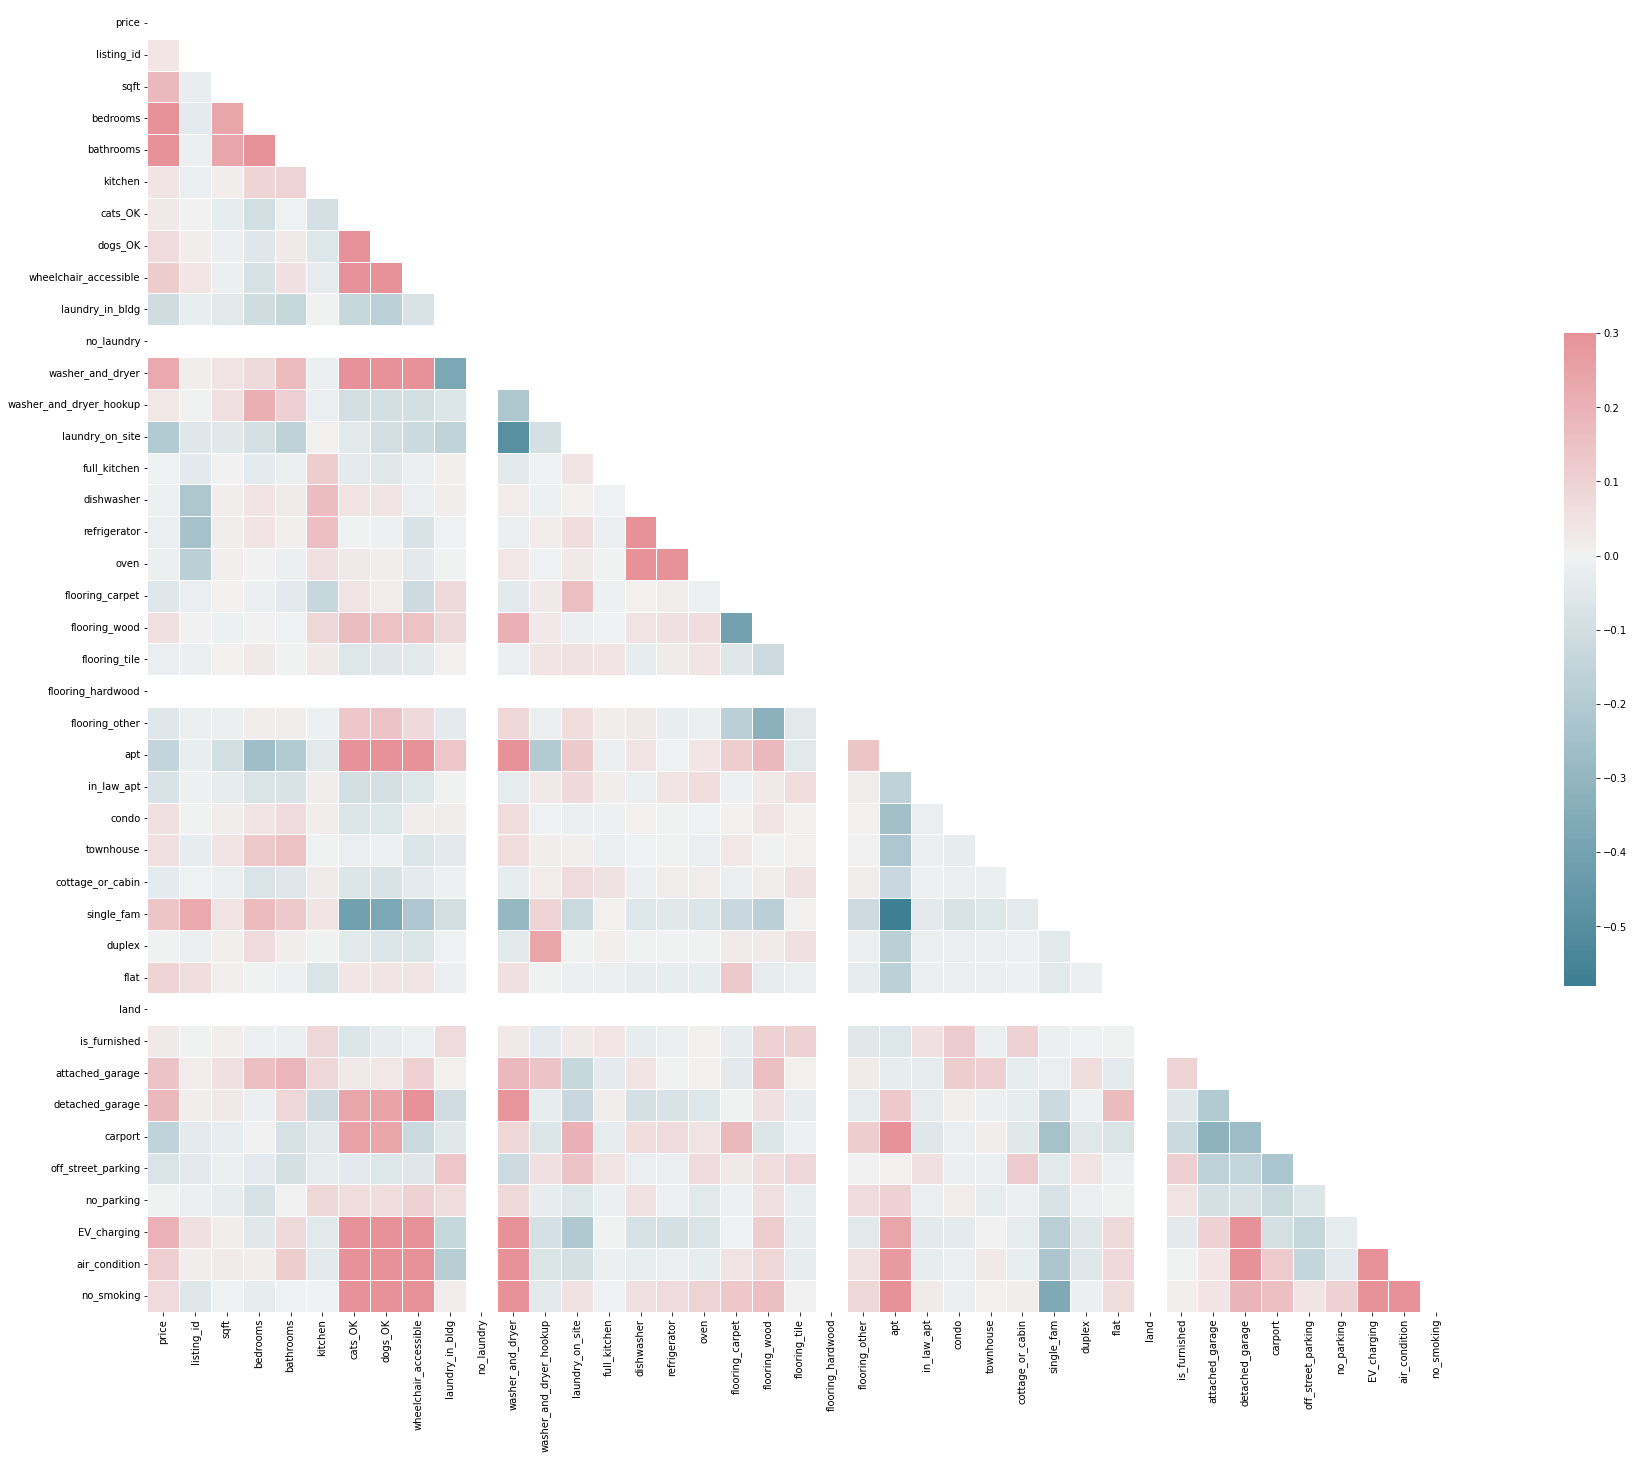

In [87]:
# visualize heatmap of correlation coefficient matrix to analyze correlations between each of the variables within the dataset:
# compute correlation coefficient matrix (but be sure to filter out any non-numeric columns such as cities)
#show heatmap plot of correlation (sort of a heatmap of a correlation matrix)
#calculate the correlations of each variable to price
def corr_heatmap(df, outcome_var):
    # for purposes of finding correlations with price, create a new Index object and convert to list with all numeric (int64 & float) columns from the  dataframe
    # we will exclude all indicator variables (ie, data type of 'uint8') since some have so many groups
    numeric_RHS = df.select_dtypes(include=['int64','float64']).columns  #exclude indicator variables
    #drop the outcome var from this df since we should only include RHS variables for this
    numeric_RHS = numeric_RHS.drop([outcome_var]) 
    #also, convert numeric_RHS to list:
    numeric_RHS_lis  = list(numeric_RHS)
    #calculate correlation of each RHS column with respect to the dependent variable
    corr = df[[outcome_var] + numeric_RHS_lis].corr()
    #Initialize the heatmap plot
    f, ax = plt.subplots(figsize=(40,24))
    #Create a mask to generate an upper triangular shape
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    #Set up a color map with a diverging palette of 3 colors
    cmap= sns.diverging_palette(220,10, as_cmap = True)
    #Notice the plot has a triangular shape, and the levels and intensity of positive and negative correlations are shown with 2 diverging colors.
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws ={"shrink": .5})

#heatmap of correlation coefficient matrix:
corr_heatmap(df, 'price') #NB: For this heatmap, note that a darker red color conveys higher positive correlation, white indicates no correlation, and blue indicates higher negative correlation)


## Analysis of  correlation coefficient matrix:

### Many of the variables do not have any more than a slight positive or negative correlation with rental prices.

### Namely, only about 8 of the 40+ variables have more than a slight or moderate positive correlation: both garage indicators (detached or attached); single family property type (single_fam); electric vehicle charger indicator (EV_charging); washer and dryer is included indicator (washer_and_dryer); sqft, and especially the number of bedrooms & bathrooms, respectively.

### Even fewer of the variables have a noticeable negative correlation, with only the laundry service available on site indicator (ie, laundry_on_site) showing a moderate negative correlation. Several other variables have slight negative correlations with price: apartment property type (apt); no laundry service (no_laundry) indicator); in law apt property type; and carport indicator.  

## Potential multicollinearity problems?

### Potentially a more problematic issue suggested by the heatmap plot is the possibility of multicollinearity: ie, correlation between 2 or more of the (potential) independent variables.

### For example, sqft is moderately positively correlated with *2* other variables: # of bedrooms & bathrooms, respectively!

### In addition, several of the indicator variables have a moderate degree of positive correlation with 2 or more of the other indicator variables, such as between apt (ie, apartment housing type) and wheelchair accessibility as well as allowing of cats (ie, cats_OK) or dogs. 

### In addition, no_smoking, electric vehcile charging, and air conditioning attributes/amenities all positively correlate (somewhat) with the above wheelchair, cats_OK, and dogs_OK attributes. 

### However, to be certain as to whether these low to moderate correlations among the RHS variables actually translate to a high degree of multicollinearity, we need to calculate the *VIF* (ie, variance inflation factor). See below for more details:

## How should we contend with this fairly widespread multicollinearity?

### Since we are concerned with *interpreting* coefficients and examining *determinants* of rental prices--in addition to simply predicting rental prices--multicollinearity could potentially be quite problematic. We would only be wise to ignore multicollinearity if our only concern was to derive accurate predictions.

## How do we mitigate multicollinearity?

### We should estimate variance inflation factor (VIF), and potentially remove columns that have a sufficiently high VIF, which is sometimes defined as being >= 5. 

### Let's estimate VIF below, and then remove the worst offenders of multicollinearity:

In [133]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


def estimate_VIF(df, outcome_var):
    """Estimate VIF of the various covariates with each other"""
    # exclude outcome variable
    X = df.drop(columns=[outcome_var])  # exclude outcome variable since we are only interested in the RHS variables (examining correlations among each other)
    # select only *numeric* columns since we cannot compute VIF for non-numeric data types (ie, object or categorical, etc.)
    X = X.select_dtypes(include=[np.number]) # select only numeric data types
    # add constant (since we are estimating an OLS to derive VIF)
    X = add_constant(X)
    # estimate VIF (for all possible RHS vars):
    VIF = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)  # estimate VIF
    
    return VIF  # return VIF estimate as DataFrame


VIF = estimate_VIF(df, 'price')

# sanity check 
print(f'VIF--ie, measure of multicollinearity:\n{VIF}')

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF--ie, measure of multicollinearity:
const                        0.000000
listing_id                  12.460338
sqft                         1.087885
bedrooms                     2.405875
bathrooms                    2.239548
kitchen                      1.126123
cats_OK                      5.083465
dogs_OK                      5.199877
wheelchair_accessible        1.841604
laundry_in_bldg              4.976657
no_laundry                   1.328968
washer_and_dryer            13.078297
washer_and_dryer_hookup      2.365040
laundry_on_site              8.637382
full_kitchen                 1.037512
dishwasher                   1.436893
refrigerator                 1.604690
oven                         1.360149
flooring_carpet              2.360818
flooring_wood                3.035893
flooring_tile                1.198358
flooring_hardwood                 NaN
flooring_other               1.992724
apt                          6.211991
in_law_apt                   1.461934
condo      

## NB: Notice several of the idnicator variables have very high VIF. Both a priori and the heatmap indicate moderate correlation among the bedroom, bathroom, and sqft columns, but it's not necessarily borne out in the VIF calculations. So we will keep each of these 3 columns, but remove them later if needed!!!

## Next, let's remove columns with very high VIF--ie, VIF >10:

In [134]:
def drop_high_collinear_cols(VIF, df):
    """Drop columns from main dataset if VIF is very high"""
    # identify cols with VIF >= 10
    VIF = VIF.loc[VIF >=10]  # subset VIF results to cols with high VIF

    # get a list of the cols with high VIF-- NB!: slice to skip the 1st col since that is merely the *constant* (intercept)!
    high_VIF_cols_to_drop = VIF.index[1:].to_list() # slice to skip the 1st col since it's the constant term, not an actual col
    print(f'The columns with high VIF are:/n{high_VIF_cols_to_drop}')
    # drop the cols with high VIF
    df = df.drop(columns=high_VIF_cols_to_drop)

    # sanity check
    print(f'The columns in the dataset are now:/n{df}')
    return df

df = drop_high_collinear_cols(VIF, df)


The columns with high VIF are:/n['washer_and_dryer', 'week', 'month', 'year']
The columns in the dataset are now:/n       listing_id   sqft           city  price  bedrooms  bathrooms  \
975    7400340992   9540     San Rafael   1600         2        1.0   
1135   7400607232  11000      Fairfield   2277         3        1.0   
1136   7400609792   9260        Fremont   2498         2        2.0   
1137   7400614400   9980         Dublin   2225         2        2.0   
1138   7400614912   9980      Pittsburg   2225         2        2.0   
...           ...    ...            ...    ...       ...        ...   
15137  7448673792   4000     Santa Rosa   1685         1        1.0   
15138  7448727040   3100         Soquel   1850         1        1.0   
15139  7448891904  16780  Boulder Creek   4000         3        2.0   
15140  7449138176   5250     Santa Cruz   1800         1        1.0   
15141  7449140224   5900     Santa Cruz   1800         1        1.0   

                                

###  VIF & multicollinearity--cont'd: Next, let's remove several specific columns that we know a priori estimate similar things, meaning that including each of them would be redundant.

### For example: dogs_OK & cats_OK (remove one of them since they are likely very correlated with one another). 

### In addition, sqft is another likely candidate. Its VIF is not very high, but it measures the size of a home, which makes it similar to that of the # of bedrooms or bathrooms data. An alternative is to remove the number of bedrooms or bathrooms, but we should keep at least one of these latter 2 variables. 

### Caveat: The apt property type indicator will be *removed later* since it will serve as a *reference group* among the property type dummy variables!!

### 

In [136]:
def remove_redundant_vars(df, list_of_redundant_cols):
    return df.drop(columns=list_of_redundant_cols)


# specify a list of redundant cols
redundant_cols_lis = ["dogs_OK", "sqft", "kitchen"]

df = remove_redundant_vars(df, redundant_cols_lis)

# sanity check
def test_redundant_cols_not_in_df(df, list_of_redundant_cols):
    if redundant_cols_lis not in df.list_of_redundant_cols.to_list():
        print(True)
    else:
        print(False) 

test_redundant_cols_not_in_df(df, redundant_cols_lis)

True


## Data cleaning--cont'd:

### Next, we will remove any of the indicator variable columns in which *all* of the rows for the given column is equal to *only* zeros (ie, all 0s):

#### For example--at least after the previous data cleaning steps--land is a very uncommon property/housing type, so it might have only 0s. In addition, flooring_hardwood is a very uncommon floor type for the listings, so it might also have only 0s (especially ).

In [139]:
def remove_cols_with_only_0s(df):
    """Remove any columns that have only 0s."""
    df = df.loc[:, (df != 0).any(axis=0)]
    return df


df = remove_cols_with_only_0s(df)

In [164]:
""" Sanity check--the 'land' col should have at least one 1 value, and not comprise just 0s. 
Otherwise, the remove_cols_with_only_0s() function should have removed the entire column"""

def test_land_and_hardwood_col_vals(df):
    if 'land' and 'flooring_hardwood' in df:
        # print value_counts() to verify that there's at least 1 non-zero value 
        print(f'land col value counts:\n{df.land.value_counts()} \n\n')
        print(f'flooring_hardwood col value counts:\n {df.flooring_hardwood.value_counts()}')
    
    elif 'land' not in df and 'flooring_hardwood' in df:
        print("The land col was removed by the remove_cols_with_only_0s() function.\n")
        print(f'flooring_hardwood col value counts:\n{df.flooring_hardwood.value_counts()}')

    elif 'flooring_hardwood' not in df and 'land' in df:
        print("The flooring_hardwood col was removed by the remove_cols_with_only_0s() function.\n")
        print(f'land col value counts:\n{df.land.value_counts()} \n\n')

    else:
        print("The land & flooring_hardwood cols were removed by the remove_cols_with_only_0s() function.")

# apply function to check on values/existence of land col
test_land_and_hardwood_col_vals(df)

The flooring_hardwood col was removed by the remove_cols_with_only_0s() function.


land col value counts:
0    13985
1        5
Name: land, dtype: int64 




## Let's examine whether the distributions of price, # of bedrooms, etc. differs by Bay Area subregion:

### NB!: see following for how to use .melt() and then do a buxplot of separate groups: <https://stackoverflow.com/questions/53109236/boxplot-with-groupby-two-features>

<AxesSubplot:xlabel='price'>

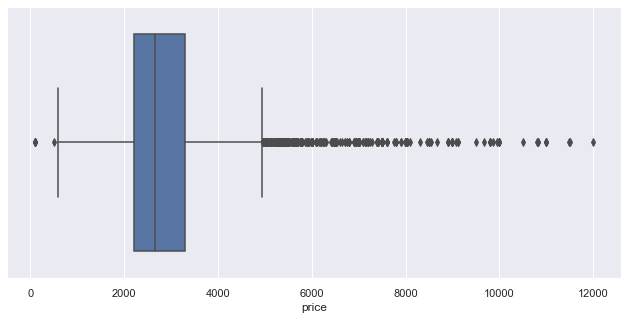

In [95]:
# boxplot of rental prices by sub_region:
def multiple_boxplot_subplot(df, col_to_plot, hue_option):
    # use plt.subplots() to allow for multiple boxplots in same figure
    fig, ax = plt.subplots(figsize=(11,5))
    return sns.boxplot(data=df, x=col_to_plot, hue=hue_option, ax=ax)

multiple_boxplot_subplot(df, 'price', 'sub_region')

### Data visualizations and data exploration-- Countplots of variables such as # of bedrooms, and include percent of total:


### Among the relatively few rental listings that are furnished, how many bedrooms do these rental listings tend to have relative to non-furnished rental listings?:

### Countplot of # of bedrooms by whether the rental is furnished:

### How does the number of bedrooms relate to the number of bathrooms?

### Boxplot of the distribution of the number of bedrooms by the number of bathrooms:

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

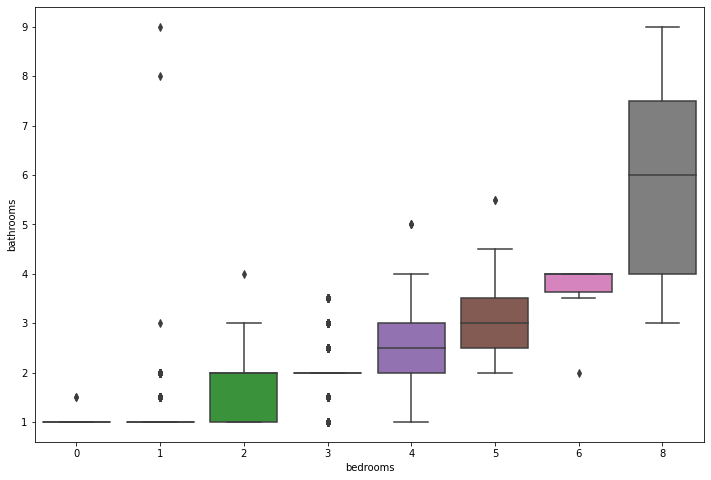

In [15]:
# boxplot of number of bedrooms- distribution by # of bathrooms
boxplot_with_y_var_and_hue(df, 'bedrooms', 'bathrooms', None)

### No listing has less than 1 bathroom, and most studios and 1-bedroom listings have 1 bathroom each. 



### In general, the number of bathrooms is typically the same or lower than the number of bedrooms, aside from studios, especially for listings with 4 or more bedrooms. 


### Next, let's examine correlations of variables with rental price (ie, the outcome variable)

In [ ]:
# scatterplot of sqft and rental price

In [ ]:
# scatterplot of # of bedrooms and rental price

## Next, let's examine the data at the subregion level (ie, sfc vs sby, etc.) and then at the city level

### Rental prices & sqft by subregion: 

In [21]:
### group data by subregion level-- price & sqft summary stats
def groupby_multiple_aggs_and_cols(df, groupby_col, agg_col_1, agg_col_2):
    df_groupby = df.groupby([groupby_col]).agg(
        {agg_col_1: ['count', 'max', 'mean', 'median', 'std', 'min']},
        {agg_col_2: ['count', 'max', 'mean', 'median', 'std', 'min']})
    return df_groupby


# 

print(f"Comparing rental prices & sqft by subregion:\n{groupby_multiple_aggs_and_cols(df, 'sub_region', 'price', 'sqft')}")


Comparing rental prices & sqft by subregion:

           price                                              
           count    max         mean  median          std  min
sub_region                                                    
eby         3677  11000  2555.202339  2460.0   805.515268  600
nby         1230  11500  2667.516260  2500.0  1128.078741  100
pen         2358  12000  3282.591179  3158.5  1219.151065  700
sby         3241   9950  2884.941685  2728.0   934.667199  590
scz          160   6500  2640.356250  2300.0  1119.136490  950
sfc         1451  11495  3162.416265  2884.0  1435.375434  100


In [ ]:
## visualize and compare avg prices by subregion

## Since we have time series/panel data, let's examine the data over time & examine for autocorrelation

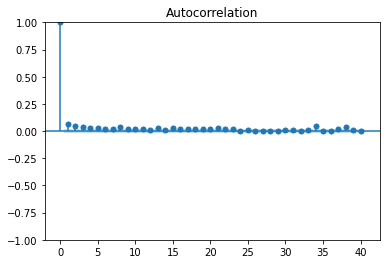

In [8]:
import statsmodels.api as sm

def transform_to_time_series(df, time_series_col):
    df_ts = df.set_index(time_series_col)
    return df_ts

df_ts = transform_to_time_series(df, 'date_posted')

def auto_corr_plot(df_ts, col):
    sm.graphics.tsa.plot_acf(df_ts[col], lags=40)
    plt.show()

# show  autocorrelation (ACF) plot wrt rental prices over time
auto_corr_plot(df_ts, 'price')

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


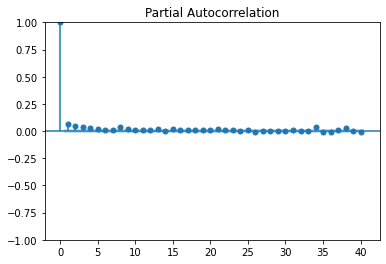

In [14]:
def partial_auto_corr_plot(df_ts, col):
    sm.graphics.tsa.plot_pacf(df_ts[col], lags=40)
    plt.show()

# show partial autocorrelation plot
partial_auto_corr_plot(df_ts, 'price')

## Autcorrelation plots:

### The ACF and PACF plots do *not* indicate autocorrelation, since none of the lagged error terms have anything other than very low correlations with the non-lagged error.

### However, we should test this intuition more rigorously by using a Durbin-Watson statistical hypothesis test *after* we run the OLS regression model(s)!

### *NB:* a Durbin-Watson test requires measuring a regression model since the test uses residuals to compute the test statistic.  

### Thus, let's start by computing an OLS on rental price, but only use a few independent (RHS) variables to keep the model simple (objective is mainly just to do a D-W test): 


In [19]:
from statsmodels.formula.api import ols

def implement_linear_OLS(ols_formula_r_syntax, df):
    return ols(ols_formula_r_syntax, data=df).fit()

ols_formula_for_d_w  = 'price ~ bedrooms + bathrooms + sqft'

ols_model =ols(ols_formula_for_d_w,data=df).fit()

# sanity check
print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1529.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:10:47   Log-Likelihood:            -1.0000e+05
No. Observations:               12117   AIC:                         2.000e+05
Df Residuals:                   12113   BIC:                         2.000e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1563.9317     21.793     71.763      0.0

## Next, let's implement a Durbin-Watson test

### NB: The decision rule for a Durbin-Watson test is as follows: the null hypothesis states there is no autocorrelation, while the alternative hypothesis asserts there is autocorrelation.

###  Reject the null hypothesis of no autocorrelation if the test statistic significantly deviates from a value of 2, especially if it's close to 0 (positive autocorrelation) or 4 (negative autocorrelation), otherwise fail to reject the null hypothesis of no autocorrelation.  

### *In more concise terms*, a test statistic of 2 (or even approximately ranging from 1.5 to 2.5) will indicate no autocorrelation.  

In [25]:
### Durbin-Watson test:

from statsmodels.stats.stattools import durbin_watson
# statsmodels.durbin_watson() method

def durbin_watson_test(ols_fitted):
    return durbin_watson(ols_fitted.resid_pearson)  # use residuals (ie, .res) of a fitted OLS regression


dw_price = durbin_watson_test(ols_model)
print(dw_price)


1.8680264577621617


## Results of Durbin-Watson test

### The D-W test statistic is 1.87, indicating that there likely is no significant level of autocorrelation. As a result, we need not make any autoregressive or other autocorrelation adjustments when running the complete OLS, panel, or other regression models below. 

### For additional documentation re: the specifics of a D-W test, see the following statsmodels doc article: <https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html>. 

## Let's also examine whether median rental prices have fluctuated signficantly over time, and see whether this has also happened across specific (or all) subregions over time:

### Lineplot of raw rental prices (ie, using overall dataset): 

<AxesSubplot:xlabel='date_posted', ylabel='price'>

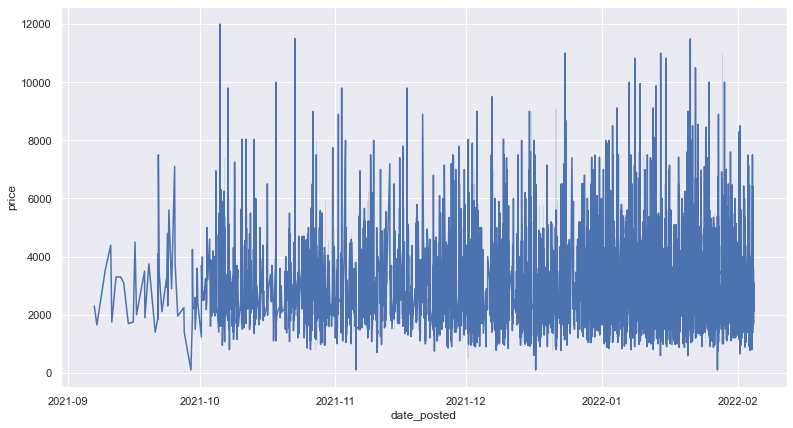

In [26]:
## Rental prices by subregion over time


# Lineplot of prices over time (ie, using overall dataset) 
plt.figure(figsize=(13, 7))

sns.lineplot(x='date_posted', y='price', data=df)

## There are clear fluctuations in rental prices, but we should examine if there are seasonality patterns that show distinct differences in rental prices by weekday, and also examine if 7-day rolling avgs show more of a clear pattern than the noise very comonn in raw time series:

## Calculate median prices, bedrooms, & sqft by weekday name:

In [54]:
df_subreg_prices_weekday = df.groupby(
    [df['date_posted'].dt.day_name(), "sub_region"])["price", "bedrooms", "sqft"].median()

df_subreg_prices_weekday


d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


price  bedrooms     sqft
date_posted sub_region                           
Friday      eby         2500.0       2.0   7500.0
            nby         2575.0       2.0   8500.0
            pen         3000.0       2.0   8760.0
            sby         2650.0       2.0   8500.0
            scz         2695.0       1.0   7200.0
            sfc         2775.0       1.0   5090.0
Monday      eby         2425.0       2.0   6590.0
            nby         2387.0       2.0   8000.0
            pen         3299.0       2.0   9000.0
            sby         2665.0       1.0   8180.0
            scz         2150.0       1.0   7500.0
            sfc         2977.0       1.0   1420.0
Saturday    eby         2400.0       2.0   7000.0
            nby         2182.0       1.0   6880.0
            pen         3160.0       2.0   9150.0
            sby         2796.0       2.0   9215.0
            scz         2550.0       1.0   7790.0
            sfc         2961.5       1.0   2085.0
Sunday      eby         2515.0       2.0   7500.0
            nby         2595.5       2.0   8500.0
            pen         3293.5       2.0   9150.0
            sby         2947.0       2.0   8820.0
            scz         2350.0       2.0   9500.0
            sfc         3200.0       1.0   4160.0
Thursday    eby         2484.0       2.0   7040.0
            nby         2441.0       2.0   8100.0
            pen         3125.0       2.0   8500.0
            sby         2764.0       2.0   8630.0
            scz         1995.0       1.0   4375.0
            sfc         2800.0       1.0   5260.0
Tuesday     eby         2474.5       2.0   6315.0
            nby         2500.0       2.0   8500.0
            pen         2975.0       2.0   8500.0
            sby         2754.5       1.0   8160.0
            scz         2200.0       2.0   8560.0
            sfc         2800.0       1.0   3770.0
Wednesday   eby         2445.0       2.0   7720.0
            nby         2473.0       2.0   7260.0
            pen         3140.0       2.0   9000.0
            sby         2706.0       1.0   8190.0
            scz         2550.0       2.0  10500.0
            sfc         2700.0       1.0   4450.0

## Notice we need to re-sort the index so the df_subreg_prices_weekday dataframe is sorted by weekday in terms of Monday, Tuesday, etc., instead of the automatic alpha ordering!!

### Sort the data by weekday in the *normal* Monday, Tuesday,..., Sunday order:

### NB: We can do this by:

### a) Specifying a list defining the *correct* order of weekday names

### b.) Using pd.Categorical() to convert the weekday names to categorical,
& 
### c) Use .sort_values() to sort the values of the DataFrame


## NB: For reference, see following: <https://stackoverflow.com/questions/53575689/pandas-groupby-how-to-sort-weekdays-in-the-correct-order-when-creating-groupby>

In [60]:
# specify a list to define the *correct* order of the weekday names
weekdays =  ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# convert weekday names to categorical, using the list values as the categories arg
df_subreg_prices_weekday.date_posted = pd.Categorical(df_subreg_prices_weekday.date_posted ,categories=weekdays)

# sort the weekday data by *correct* weekday order
df_subreg_prices_weekday = df_subreg_prices_weekday.sort_values('date_posted')


AttributeError: 'DataFrame' object has no attribute 'date_posted'

In [58]:
df_subreg_prices_weekday.sort_index(axis=0)


price  bedrooms     sqft
date_posted sub_region                           
Friday      eby         2500.0       2.0   7500.0
            nby         2575.0       2.0   8500.0
            pen         3000.0       2.0   8760.0
            sby         2650.0       2.0   8500.0
            scz         2695.0       1.0   7200.0
            sfc         2775.0       1.0   5090.0
Monday      eby         2425.0       2.0   6590.0
            nby         2387.0       2.0   8000.0
            pen         3299.0       2.0   9000.0
            sby         2665.0       1.0   8180.0
            scz         2150.0       1.0   7500.0
            sfc         2977.0       1.0   1420.0
Saturday    eby         2400.0       2.0   7000.0
            nby         2182.0       1.0   6880.0
            pen         3160.0       2.0   9150.0
            sby         2796.0       2.0   9215.0
            scz         2550.0       1.0   7790.0
            sfc         2961.5       1.0   2085.0
Sunday      eby         2515.0       2.0   7500.0
            nby         2595.5       2.0   8500.0
            pen         3293.5       2.0   9150.0
            sby         2947.0       2.0   8820.0
            scz         2350.0       2.0   9500.0
            sfc         3200.0       1.0   4160.0
Thursday    eby         2484.0       2.0   7040.0
            nby         2441.0       2.0   8100.0
            pen         3125.0       2.0   8500.0
            sby         2764.0       2.0   8630.0
            scz         1995.0       1.0   4375.0
            sfc         2800.0       1.0   5260.0
Tuesday     eby         2474.5       2.0   6315.0
            nby         2500.0       2.0   8500.0
            pen         2975.0       2.0   8500.0
            sby         2754.5       1.0   8160.0
            scz         2200.0       2.0   8560.0
            sfc         2800.0       1.0   3770.0
Wednesday   eby         2445.0       2.0   7720.0
            nby         2473.0       2.0   7260.0
            pen         3140.0       2.0   9000.0
            sby         2706.0       1.0   8190.0
            scz         2550.0       2.0  10500.0
            sfc         2700.0       1.0   4450.0

## Lineplot of rental prices by weekday:


# NB!: I need to *sort* the df_subreg_prices_weekday dataframe by weekday in terms of Monday, Tuesday, etc., instead of the automatic alpha ordering!!

## Here's a possible solution: <https://stackoverflow.com/questions/35193808/re-order-pandas-series-on-weekday>

## Also see 



<AxesSubplot:title={'center':'Median Rental Prices By Weekday & Subregion'}, xlabel='date_posted', ylabel='price'>

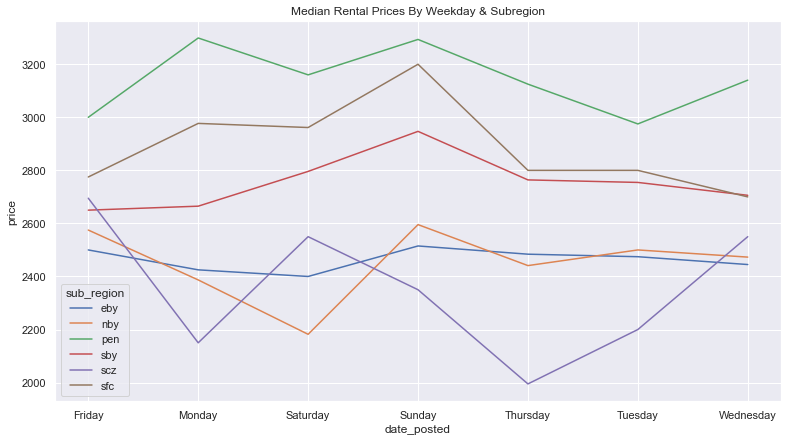

In [59]:
def lineplot_seaborn(figsize_tuple, df, datetime_col, col_y_axis, hue_col_option, plot_title):
    plt.figure(figsize=figsize_tuple)  # specify plot's figure size
    pl = sns.lineplot(x=datetime_col, y= col_y_axis, data=df, hue=hue_col_option)  
    pl.set(title= plot_title) # specify title
    return pl

lp_title_weekday_median_subreg = "Median Rental Prices By Weekday & Subregion"  # specify plot's title

lineplot_seaborn((13, 7), df_subreg_prices_weekday, 'date_posted', 'price',  'sub_region', lp_title_weekday_median_subreg)


## Next, let's compare rental prices on a daily basis by a 7-day rolling avg:

## NB!!: Check following for an example: <https://datavizpyr.com/how-to-make-a-time-series-plot-with-rolling-average-in-python/>

## Look up plot entitled "Time Series Plot with 7-day rolling average: Pandas and Seaborn"

## Group data by week over week & subregion

In [83]:
## Get groupby of median for subregion
def groupby_single_agg_median(df, col_to_group, col_agg_calc):
    return df.groupby(col_to_group)[col_agg_calc].median()


# specify cols to agg
subregion_and_date = ['sub_region', 'date_posted']

# median prices by subregion & date_posted 
sub_region_median_prices = groupby_single_agg_median(df, subregion_and_date, 'price')

df_subreg_prices_weekly = df.groupby(
    [df['date_posted'].dt.week, df['date_posted'].dt.year, "sub_region"])["price", "bedrooms", "sqft"].median()
        
df_subreg_prices_weekly




d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


price  bedrooms    sqft
date_posted date_posted sub_region                          
1           2022        eby         2380.0       2.0  1263.0
                        nby         2182.0       1.0  7130.0
                        pen         3195.0       2.0  9300.0
                        sby         2795.0       2.0  8170.0
                        scz         2600.0       2.0  8440.0
...                                    ...       ...     ...
52          2022        eby         2500.0       2.0  8510.0
                        nby         2100.0       1.0  7250.0
                        pen         2997.5       1.0  8500.0
                        sby         2601.0       1.0  8000.0
                        sfc         3222.5       2.0  6320.0

[113 rows x 3 columns]

## Lineplot of week over week subregion prices:

<AxesSubplot:title={'center':'Week over Week Median Rental Prices By Subregion'}, xlabel='date_posted', ylabel='price'>

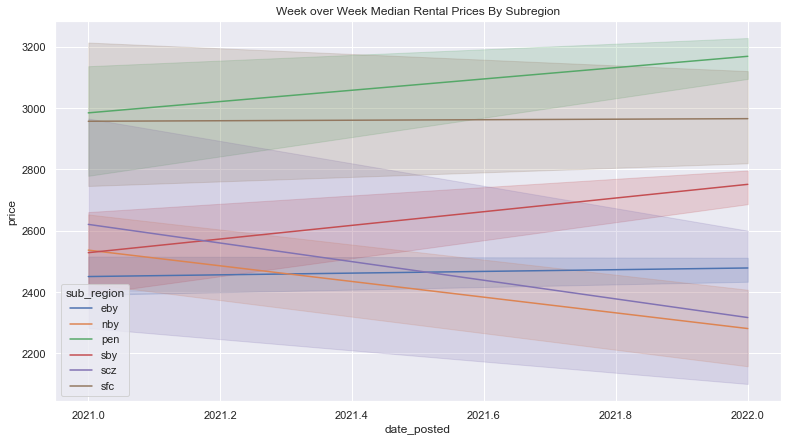

In [84]:
lp_title_weekday_median_subreg = "Week over Week Median Rental Prices By Subregion"  # specify plot's title

lineplot_seaborn((13, 7), df_subreg_prices_weekly, 'date_posted', 'price',  'sub_region', lp_title_weekday_median_subreg)


d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Week over Week Median Rental Prices (overall)'}, xlabel='date_posted', ylabel='price'>

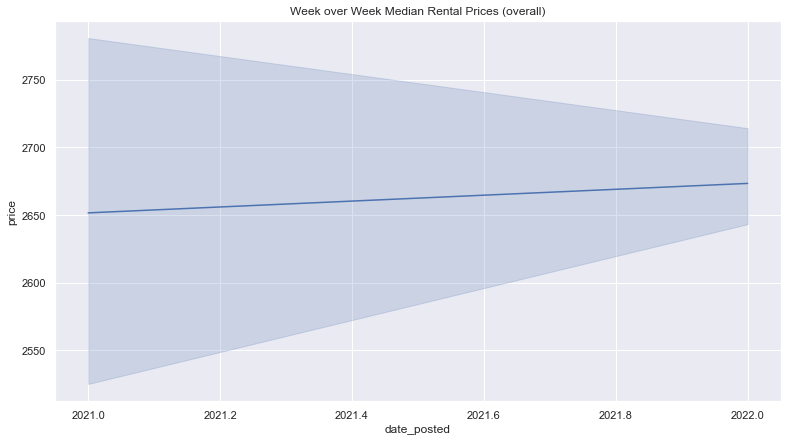

In [81]:
df_prices_weekly = df.groupby(
    [df['date_posted'].dt.week, df['date_posted'].dt.month, df['date_posted'].dt.year])["price", "bedrooms", "sqft"].median()

df_prices_weekly

lp_title_weekday_median_subreg = "Week over Week Median Rental Prices (overall)"  # specify plot's title

lineplot_seaborn((13, 7), df_prices_weekly, 'date_posted', 'price', None, lp_title_weekday_median_subreg)



## The Week over Week lineplot indicates a very gradual increase in overall weekly median rent prices.

## Let's next examine month over month data, since this would likely show more pronounced increases in median rental prices.

## Monthly rental prices:

### NB: I need to account for the year as well as month for deriving monthly time series, since dt.month does not itself account for differences in year! 

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Month over Month Median Rental Prices Overall'}, xlabel='date_posted', ylabel='price'>

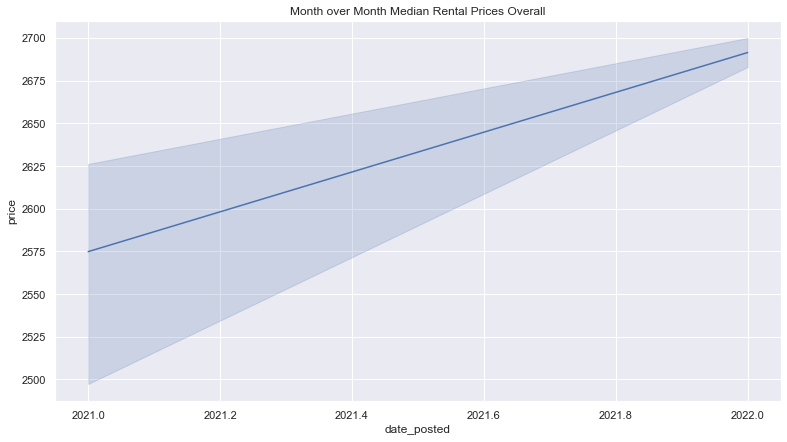

In [88]:
df_prices_monthly = df.groupby(
    [df['date_posted'].dt.month, df['date_posted'].dt.year])["price", "bedrooms", "sqft"].median()


title_prices_monthly = "Month over Month Median Rental Prices Overall"  # specify plot's title

lineplot_seaborn((13, 7), df_prices_monthly, 'date_posted', 'price', None, title_prices_monthly)



## Interpretation: The month over month median rental prices lineplot indicates that--overall--median rental prices have consistently increased month over month between September 2021 and February 2022.

## Over this 5 month period, median rental prices have increased cummulatively by ~$125 from  $2,575 to approximately $2,700.

## The month over month increases appear to be happening at a very similar rate of growth, with no one month or set of months experiencing any particularly sharp increases in monthly prices.

## From a regression & statistical model perspective, this likely indicates autocorrelation issues since there is clearly a positive trend of rental prices (the outcome variable) over time.  

## Let's now examine whether monthly rental prices have fluctuated at different levels within the 6 subregions:

## Monthly rental prices by subregion:

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Month over Month Median Rental Prices By Subregion'}, xlabel='date_posted', ylabel='price'>

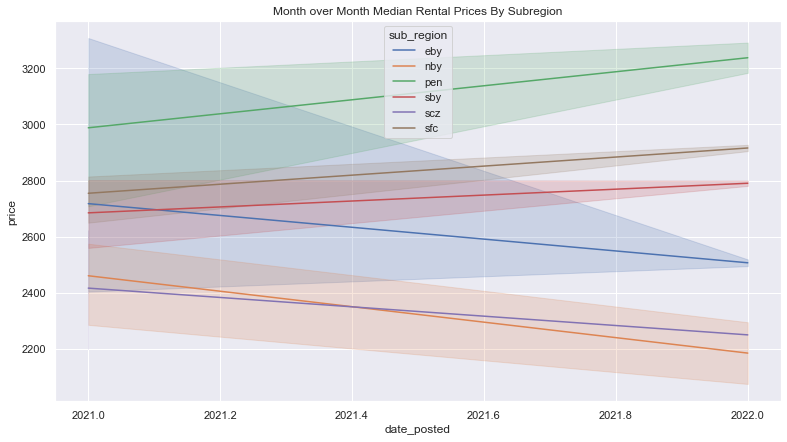

In [79]:
df_prices_monthly_subregion = df.groupby(
    [df['date_posted'].dt.month, df['date_posted'].dt.year, df['sub_region']])["price", "bedrooms", "sqft"].median()


title_prices_monthly_subregion = "Month over Month Median Rental Prices By Subregion"  # specify plot's title

lineplot_seaborn((13, 7), df_prices_monthly_subregion, 'date_posted', 'price', 'sub_region', title_prices_monthly_subregion)



## NB: Interestingly, we see that half of the 6 Bay Area subregions (including Santa Cruz) actually experienced small declines in median rental prices. 

### These subregions even include 1 heavily populated region of the SF Bay Area. Namely, subregions that saw reductions in rental prices include: Santa Cruz, the North Bay, and the East Bay.

### However, the other 3 subregions--namely, the Peninsula, South Bay, and San Francisco--experienced modereately high increases in monthly rental prices, obviously enough to counteract the slight downward trajectory of the other subregions' rental prices over this same period.


## Next, we should determine whether the time series data has significant autocorrelation issues:  

### Calculate and plot autocorrelation function for monthly



In [89]:
from statsmodels.graphics.tsaplots import plot_pacf

### Also see time series forecasting methods in Python/Pandas: <11 Classical Time Series Forecasting Methods in Python (Cheat Sheet) (2018)

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
>>

## Next, let's examine whether the time series is stationary:

### NB: If the time series data is not, then we should create lags as needed to achieve stationarity!

## Now, let's proceed to regression analysis:



## Since we have numerous time periods, and we have panel data with linear trend of autocorrelation (epecially since rho > 1/3), we can use a First-Differences approach to mitigate autocorrelation and also most likely mitigate omitted variable bias.  

#### One of the other underlying statistical reasons for using first-differences is we have demonstrated that there are signficant levels of autocorrelation (due to a positive trend in rental prices). 

#### To be more specific, since rho > 1/3, 1st differences can reduce the extent of autocorrelation. See following for a discussion of some of the linear algebra underlying the econometric theory at play here: <http://fmwww.bc.edu/ec-c/S2004/771/ec771.S2004.ps6.key.pdf>

#### NB2: However, First-differencing is *not guaranteed* to mitigate autocorrelation. It really only removes effects of a *linear trend* from estimating of autocorrelation.  

## Data exploration--cont'd:

### Finally, let's examine for whether any of the sets of indicator variables --ie, which have multiple groups such as the laundry and washer+dryer indicators--are perfectly collinear:

### Specify reference group column for each group of indicator variables such as the property/home type variables (apt, duplex, etc), which we will need to remove : 

In [27]:
# 
def specify_dict_of_reference_groups(**key_val_ref_group_col_names):
    return key_val_ref_group_col_names

dict_of_ref_group_col_names = specify_dict_of_reference_groups( flooring_type = 'flooring_carpet', housing_type = 'apt', laundry_indicators = 'laundry_in_bldg', parking_options = 'no_parking') 

# sanity check
dict_of_ref_group_col_names

{'flooring_type': 'flooring_carpet',
 'housing_type': 'apt',
 'laundry_indicators': 'laundry_in_bldg',
 'parking_options': 'no_parking'}

In [ ]:
## group data by city level



In [ ]:
## visualize and compare avg prices by city

In [ ]:
### group data by housing type--ie, apt (apartment), single_fam (ie, single family), townhouse, etc.



## Regression Analysis:

### Create city & SF Bay Area sub_region indicator vars"

## D.) Prepare the data for regression analysis-- bifurcate the DataFrame into the outcome variable and the covariates (ie, RHS variables), respectively:

### 1) Remove any irrelevant columns that we will definitely *not* use for the regression analysis.

### 2) Remove reference group for each set of indicator variables that have multiple categories/groups-- 
### e.g., -- the washer and dryer indicators ('no_laundry', 'washer_and_dryer', etc.); 
### the flooring indicators (ie, with the 'flooring_' prefix); 
### the parking indicators; 
### and the rental home type indicators ('apt', 'duplex', etc.)!! 

### 3) Remove variables that--either a priori or especially via the coefficient correlation matrix--have a high degree of multicollinearity, especially full_kitchen given we already have kitchen in the dataset.


###  3)  Bifurcate dataset into train & test/validation


In [141]:
## 1) Remove cols that we will *not* use for regression analysis:

# remove these cols from dataset
def remove_non_OLS_cols(df, list_of_non_OLS_cols):
    return df.drop(columns=list_of_non_OLS_cols)

# specify cols we will *not* use in the ression models:
non_OLS_cols = ["listing_id", "attr_vars", "date_of_webcrawler"] 


df = remove_non_OLS_cols(df, non_OLS_cols)

# sanity check
print(f"{df.columns}")

Index(['city', 'price', 'bedrooms', 'bathrooms', 'date_posted', 'region',
       'sub_region', 'cats_OK', 'wheelchair_accessible', 'laundry_in_bldg',
       'no_laundry', 'washer_and_dryer_hookup', 'laundry_on_site',
       'full_kitchen', 'dishwasher', 'refrigerator', 'oven', 'flooring_carpet',
       'flooring_wood', 'flooring_tile', 'flooring_other', 'apt', 'in_law_apt',
       'condo', 'townhouse', 'cottage_or_cabin', 'single_fam', 'duplex',
       'flat', 'land', 'is_furnished', 'attached_garage', 'detached_garage',
       'carport', 'off_street_parking', 'no_parking', 'EV_charging',
       'air_condition', 'no_smoking', 'day_of_week'],
      dtype='object')


In [ ]:
# 2.) Remove reference group for each set of indicator variables with multiple groups
def remove_reference_group_for_indicator_vars(df, ref_group_dummy):
    return df.drop(columns = ref_group_dummy, axis=1)

# remove ref group for laundry indicators


# remove ref group for flooring indicators

# remove ref group for home/property type indicators--e.g., apt, etc.

# remove ref group for parking indicators


## 4) Split overall dataset into training & validation/test data:

In [ ]:
#  4)  bifurcate dataset into train & test data
def split_to_train_and_test_data(df):
    pass # split into 70% train & 30% validation

## E.) Regression analysis!!

### NB: The statsmodels smf API allows us to use R-like OLS formula syntax. This provides a feature that automatically parses object/str columns that are categorical-like--such as the 'city' column--to numeric indicator variables, and will also automatically remove one of the groups as a reference group!!

### Thus, the smf API is generally preferred over the sm API in any case where one or more of the following constraints are at play: 1.) we do *not* want to use one hot encoding --e.g., if we want to interpret each categorical , and 2.) there are *numerous* groups per category, so for sake of minimizing memory usage smf.ols() is better than sm.OLS() since we can avoid using (say) Pandas' get_dummies() method, which would result in an unrealistically high number of columns.

## E1) Implement Pooled OLS regression:

### E1a) Use a Pooled OLS specification with *just* sub_region indicator variables. We will introduce city-level indicators as well, but in a later specification!!

### NB: The linearmodels.panel package contains modules that can implement Pooled OLS, fixed effects, random effects, and other panel models.

### See linearmodels' doc: <https://bashtage.github.io/linearmodels/panel/examples/examples.html>

In [34]:
df.columns

Index(['city', 'price', 'bedrooms', 'bathrooms', 'kitchen', 'date_posted',
       'region', 'sub_region', 'cats_OK', 'wheelchair_accessible',
       'laundry_in_bldg', 'no_laundry', 'washer_and_dryer_hookup',
       'laundry_on_site', 'full_kitchen', 'dishwasher', 'refrigerator', 'oven',
       'flooring_carpet', 'flooring_wood', 'flooring_tile',
       'flooring_hardwood', 'flooring_other', 'apt', 'in_law_apt', 'condo',
       'townhouse', 'cottage_or_cabin', 'single_fam', 'duplex', 'flat', 'land',
       'is_furnished', 'attached_garage', 'detached_garage', 'carport',
       'off_street_parking', 'no_parking', 'EV_charging', 'air_condition',
       'no_smoking', 'day_of_week', 'week', 'month', 'year'],
      dtype='object')

## NB!: When using Pooled OLS for a sub_region and week time effects with the *full set of RHS covariates*, the reg *cannot* be fitted properly since the RHS do *not* have full column rank (prob due to collinearity issues).   

### As a result!: I need to run the PanelOLS() multiple times, removing each of the RHS one by one, and try to pinpoint which column or columns are the culprit.

### NB2: Keep in mind that a very small set of RHS covariates did work ok--namely: bedrooms, bathrooms, condo, etc. 

### So if it's too time-consuming to try the collectively exhaustive approach, then just run the PanelOLS with 12 or so covariates. 

In [68]:
dict_of_ref_group_col_names

{'flooring_type': 'flooring_carpet',
 'housing_type': 'apt',
 'laundry_indicators': 'laundry_in_bldg',
 'parking_options': 'no_parking'}

In [173]:
# smf statsmodels API for R-like regression formula syntax
import statsmodels.formula.api as smf

## implement pooled OLS with *just* subregion indicators and week-over-week time effects

import statsmodels.api as sm
from linearmodels.panel import PooledOLS



def fit_Pooled_OLS(df, entity_effects, time_effects, outcome_var, irrelevant_cols_list, dict_of_ref_group_col_names):
  ## NB: we need to index the dataset along the entity and time (respectively) that we want for fixed/random effects:
  #set index to the entity and time for transforming dataset to a proper panel 
  df = df.set_index([entity_effects, time_effects]) # set index to transform to panel dataset

  # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
  print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')

  # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
  # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
  list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings
  
  # a) remove each reference group col from dataset (ie, before running regression)
  df = df.drop(columns=list_of_ref_group_cols)

  #b) also, remove any irrelevant cols
  df = df.drop(columns=irrelevant_cols_list)  # remove irrelevant cols such as 'day_of_week'

  # From df dataset, obtain all RHS covariates --remove outcome var:
  RHS = df.drop(columns = [outcome_var])  # remove outcome var and entity+time effects cols 

  # compute total number of all RHS variables (having *removed* the reference groups, entity+time effects, and irrelevant cols)   
  num_cols = RHS.shape[1]   # obtain number of  RHS cols
  print(f'The number of covariates (ie, RHS) is:\n{num_cols} columns') # print number of RHS covariates

  # Estimate OLS model using R-like OLS formula syntax
  # specify a list of covariates/RHS:
  # RHS_vars = RHS_vars_sans_categorical.columns.to_list()

  # add intercept (aka, constant) to RHS:
  RHS = sm.add_constant(RHS)

  # instantiate Pooled OLS model-- (NB: we cannot use entity effects or time effects since this is not a fixed, random, or mixed effects model)
  mod = PooledOLS(dependent = df[outcome_var], 
  exog = RHS) 
  
  # fit model with clustered standard errors (to help account for within-cluster correlations):
  pooled_res = mod.fit(cov_type='clustered', cluster_entity=True)
  # pooled_res = mod.fit()
  

  # print results
  print(pooled_res)
  # return fitted Pooled OLS model res:
  return pooled_res



# fit Pooled OLS with sub_region entity and week (over week) time effects

# specify entity and time cols for fixed effects
subregion_entity = "city"  #entity effect
# 
time_entity_week = "week"  # time effect

# specify outcome var name
outcome_var = "price"

# specify columns that are irrelevant (ie, not usable) to the regression model
irrelevant_cols = ['sub_region', 'date_posted', 'region', 'day_of_week',  'year', 'month']

# fit and return Pooled OLS model, with 
pooled_OLS_fitted = fit_Pooled_OLS(df, subregion_entity, time_entity_week, outcome_var, irrelevant_cols, dict_of_ref_group_col_names)


The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'laundry_in_bldg', 'parking_options': 'no_parking'}
The number of covariates (ie, RHS) is:
30 columns
                          PooledOLS Estimation Summary                          
Dep. Variable:                  price   R-squared:                        0.3617
Estimator:                  PooledOLS   R-squared (Between):              0.4273
No. Observations:               13990   R-squared (Within):               0.3654
Date:                Mon, Feb 28 2022   R-squared (Overall):              0.3617
Time:                        03:14:41   Log-likelihood                -1.145e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      263.61
Entities:                         120   P-value                           0.0000
Avg Ob

In [102]:
df.no_parking

975     NaN
1136    NaN
1137    NaN
1138    NaN
1139    NaN
         ..
15136   NaN
15138   NaN
15139   NaN
15140   NaN
15141   NaN
Name: no_parking, Length: 13440, dtype: float64

In [87]:
## implement pooled OLS with *both* sub_region *and* city indicators 


# ##  run OLS regression, and show output of model via statsmodels library
## fit OLS model (*with robust standard errors to deal w/ heteroskedasticity) and print output
def fit_OLS_robust_SE(df, outcome_var, irrelevant_cols, categoric_var1, categoric_var2, dict_of_ref_group_col_names):
    # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
    print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')
    
    # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
    # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
    list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings
    # remove each reference group col from dataset (ie, before running OLS)
    df = df.drop(columns=list_of_ref_group_cols)

    # compute total number of all RHS variables (having *removed* the reference group cols)   
    num_cols = df.drop(columns=[outcome_var, irrelevant_cols]).shape[1]   # obtain number of  RHS cols
    # get a list of all RHS covariates *excluding* categorical variables 
    RHS_vars_sans_categorical = df.drop(columns=[outcome_var, irrelevant_cols, categoric_var1, categoric_var2]) 
    # NB!: before estimating model, *remove* reference groups for the sets of *mutually exclusive* indicator variables--ie, housing type (e.g., apt), etc.
      # iterate over  each value of the ref group dict, and convert to str
    RHS_vars_sans_categorical = df.drop(columns=[dict_of_ref_group_col_names]  
    print(f"The reference groups for the sets of mutually exclusive indicator variables are:\n{dict_of_ref_group_col_names}")
    # Estimate OLS model using R-like OLS formula syntax
    OLS_model =  smf.ols(
        formula= f'{outcome_var} ~ {" + ".join(str(el) for el in RHS_vars_sans_categorical)} + C({categoric_var1}) + C({categoric_var2})', 
        data =df
        )   # NB: intercept term is automatically included by this smf.ols statsmodels module (unlike for sm.OLS)
    # Fit OLS model using HC3 robust standard errors: 
    reg_res = OLS_model.fit(cov_type='HC3')   #fit the OLS regression model with hetereoskedastic-robust standard errors (ie, HC3), and thereby derive the parameter estimates
    # use cov_type='HC3' to estimate standard errors that are robust to heteroskedastic (ie, non-constant) variance, to estimate more accurate standard errors. 
    print(f"Number of covariates (ie, regressor columns):\n {num_cols}.\n\nThis OLS model specification has the following columns:\n{RHS_vars_sans_categorical.columns, categoric_var1, categoric_var2}.\n\n\nThe regression model's results are as follows:\n{reg_res.summary()}")   #  print regression results  
    return reg_res  # return fitted model results so we can store it 

# specify outcome var name
outcome_var = "price"

# specify columns that are irrelevant (ie, not usable) to the OLS model
irrelevant_vars = "date_posted"

# specify categorical variable names

categ_var2 = "sub_region"

fit_OLS_robust_SE(df, outcome_var, irrelevant_vars, categ_var1, categ_var2, dict_of_ref_group_col_names)



Number of covariates (ie, regressor columns):
 43.

This OLS model specification has the following columns:
(Index(['sqft', 'bedrooms', 'bathrooms', 'kitchen', 'region', 'cats_OK',
       'dogs_OK', 'wheelchair_accessible', 'laundry_in_bldg', 'no_laundry',
       'washer_and_dryer', 'washer_and_dryer_hookup', 'laundry_on_site',
       'full_kitchen', 'dishwasher', 'refrigerator', 'oven', 'flooring_carpet',
       'flooring_wood', 'flooring_tile', 'flooring_hardwood', 'flooring_other',
       'apt', 'in_law_apt', 'condo', 'townhouse', 'cottage_or_cabin',
       'single_fam', 'duplex', 'flat', 'land', 'is_furnished',
       'attached_garage', 'detached_garage', 'carport', 'off_street_parking',
       'no_parking', 'EV_charging', 'air_condition', 'no_smoking', 'weekday'],
      dtype='object'), 'city', 'sub_region').


The regression model's results are as follows:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squa

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\statsmodels\base\model.py:1873: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 169, but rank is 166
  'rank is %d' % (J, J_), ValueWarning)


In [ ]:
OLS_model =  smf.ols(
        formula= f'{outcome_var} ~ {" + ".join(str(el) for el in RHS_vars_sans_categorical)} + C({categoric_var1}) + C({categoric_var2})', 
        data =df
        )   # NB: intercept term is automatically included by this smf.ols statsmodels module (unlike for sm.OLS)
    # Fit OLS model using HC3 robust standard errors: 
    reg_res = OLS_model.fit(cov_type='HC3')

In [84]:
df.columns

Index(['sqft', 'city', 'price', 'bedrooms', 'bathrooms', 'kitchen',
       'date_posted', 'region', 'sub_region', 'cats_OK', 'dogs_OK',
       'wheelchair_accessible', 'laundry_in_bldg', 'no_laundry',
       'washer_and_dryer', 'washer_and_dryer_hookup', 'laundry_on_site',
       'full_kitchen', 'dishwasher', 'refrigerator', 'oven', 'flooring_carpet',
       'flooring_wood', 'flooring_tile', 'flooring_hardwood', 'flooring_other',
       'apt', 'in_law_apt', 'condo', 'townhouse', 'cottage_or_cabin',
       'single_fam', 'duplex', 'flat', 'land', 'is_furnished',
       'attached_garage', 'detached_garage', 'carport', 'off_street_parking',
       'no_parking', 'EV_charging', 'air_condition', 'no_smoking', 'weekday'],
      dtype='object')

## F.)  Fixed effects models:

## F1) Fit a fixed effects model. 

### Fixed effects model--let's use the same entity & time effects as with the Pooled OLS fitted above, so we can readily compare the Pooled OLS vs fixed effects when we  sub_region & 

In [ ]:
## NB: see following for fixed effects model example (but obv change var and dataset names)
# Transform `x2` to match model
df['x2'] = df['x2'].multiply(df['time'], axis=0)
# District fixed effects
df['delta'] = pd.Categorical(df['district'])
# State-time fixed effects
df['eta'] = pd.Categorical(df['state'] + df['year'].astype(str))
# Set indexes
df.set_index(['district','year'])

from linearmodels.panel import PanelOLS
m = PanelOLS(dependent=df['y'], exog=df[['constant','x1','x2','delta','eta']])

In [32]:
from linearmodels.panel import PanelOLS

def fit_Fixed_Effects(df, entity_effects, time_effects, outcome_var, irrelevant_cols, dict_of_ref_group_col_names):
  ## NB: we need to index the dataset along the entity and time (respectively) that we want for fixed/random effects:
  #set index to the entity and time for transforming dataset to a proper panel 
  df.set_index([entity_effects, time_effects]) # set index to transform to panel dataset

  # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
  print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')
  
  # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
  # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
  list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings
  # remove each reference group col from dataset (ie, before running regression)
  df = df.drop(columns=list_of_ref_group_cols)

  # compute total number of all RHS variables (having *removed* the reference group cols)   
  num_cols = df.drop(columns=[outcome_var, irrelevant_cols]).shape[1]   # obtain number of  RHS cols
  # get a list of all RHS covariates *excluding* categorical, irrelevant, and fixed effects cols
  RHS_vars_sans_categorical = df.drop(columns=[outcome_var, irrelevant_cols, categoric_var1, 'city']) 
  # NB!: before estimating model, *remove* reference groups for the sets of *mutually exclusive* indicator variables--ie, housing type (e.g., apt), etc.
  RHS_vars_sans_categorical = df.drop(columns=[dict_of_ref_group_col_names]  
  print(f"The reference groups for the sets of mutually exclusive indicator variables are:\n{dict_of_ref_group_col_names}")
  # Estimate OLS model using R-like OLS formula syntax

  # specify a list of covariates/RHS:
  RHS_vars = RHS_vars_sans_categorical.to_list()
  # add intercept (aka, constant)
  RHS_vars = sm.add_constant(data[RHS_vars])
  
  ## instantiate Fixed Effects model-- NB: use both entity_effects and time_effects
  # mod = PanelOLS(data.outcome_var, exog, entity_effects=True, time_effects=True)  # NB: entity_effects & time_effects will estimate the panel model using both entity effects (*sub_region in this case) & time effects (ie, )
  
  # NB: We can use the .from_formula() method to use an R-like formula syntax that's essentially equivalent to the statsmodels' smf module:
  mod = PanelOLS.from_formula('f'{outcome_var} ~ {" + ".join(str(el) for el in RHS_vars)} + EntityEffects +TimeEffects'', 
  data=df)

  # fit model using clustered SE so we can adjust for intra-cluster correlation 
  fixed_effects_fitted = mod.fit()
  # print results
  print(fixed_effects_fitted)
  # return fitted fixed effects model results
  return fixed_effects_fitted


= fit_Fixed_Effects()

SyntaxError: invalid syntax (Temp/ipykernel_27532/735719729.py, line 23)


### Fb) Run a Breush-Pagan L-M test to test fitted (pooled) OLS model w/ city & sub_region dummies re: whether pooled OLS or a fixed effects model --ie, with sub_region fixed effects-- should be used instead.

### F1b) NB: Since we have fairly small time periods and data (per entity), we might *only* want to use entity (ie, sub_region) fixed effects, *not* time fixed effects as well. 

NB: However, we can still use city dummy variables in tandem with sub_region fixed effects

### F2) Depending on results of B-P LM test--namely: *if* the test favors fixed effects over Pooled OLS, then *proceed* to step F2) a), below:

### F2) a) Run a fixed effects model *without time effects* and 2) a random effects model again *without time effects*.

### F2) b) Run a Hausman test using the 2nd specification of the fixed effects --ie, *sans time effects* and the random effects model to use as input for the hypothesis test!

### NB: Using a Hausman test, we can determine whether a fixed effects or random effects model should be preferred for analyzing the rental listing panel dataset. HGowever, as described above, we need to abide by the following constraints:

#### 1)  The Breush-Pagan LM test indicates homoskedasticity and thus favors fixed effects over Pooled OLs--ie,  The Hausman test assumes homoskedasticity 

#### 2) In addition, the test we *cannot* use time fixed effects since using them would render the Hausman test results invalid! 

In [ ]:
# Breush-Pagan L-m test
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

## NB!: Here's documentation on *how* to perform a B-P LM test in Python!!
# <https://www.statology.org/breusch-pagan-test-python/>
 
def Breush_Pagan_LM_test(fitted_pooled_OLS):
    """Take in fitted pooled OLS model, and perform B-P L-M test to determine independence of fixed effects intercepts--ie, pooled OLS vs fixed effects"""
    pass

### F2) a) 1 Run a fixed effects model *without time effects* and 2) a random effects model again *without time effects*.

### F2) b) Run a Hausman test using the 2nd specification of the fixed effects --ie, *sans time effects* and the random effects model to use as input for the hypothesis test!

In [ ]:
# Hausman test
def Hausman_test():
    """Hausman test to determine fixed vs random effects model for panel regression."""
    pass

### F3) Run a random effects model

### F4) Compare the results of the Pooled OLS, fixed effects, and randome effects models (respectively) side-by-side:

In [ ]:
from linearmodels.panel import compare

def compare_fitted_panel_models(pooled_OLS_fitted, fixed_effects_fitted, random_effects_fitted):
    print(compare({"FE": fixed_effects_fitted, "RE": random_effects_fitted, "Pooled": pooled_OLS_fitted}))



### F5) Run a mixed effects model

### NB: see statsmodels documentation on mixed effects models: <https://www.statsmodels.org/dev/mixed_linear.html?highlight=fixed%20effects>

In [ ]:


mixed_effects = smf.mixedlm('outcome ~ time * targeted * sex', df, groups = df['patient'])


## Implement Fixed Effects (*or random effects!!*) regression

### NB: The *linearmodels* package provides a set of various panel regression model methods and implementations (among other regression methods)

### linearmodels doc: <https://pypi.org/project/linearmodels/>


### Also, see full example of fixed effects using linearmodels package: <https://lost-stats.github.io/Model_Estimation/OLS/fixed_effects_in_linear_regression.html>

In [ ]:
# D) - cont'd: normalize the datasets

In [ ]:
# D) - cont'd:   use k-fold cross validation



## E.) Estimate other regression models such as xgboost regression; then interpret models, determine accuracy of models, and make predictions:

In [ ]:
# 
def xgboost_regression():
    pass

In [ ]:
# Determine accuracy of models by calculating root-mean squared error (ie, RMSE)
def calc_RMSE_accuracy(fitted_reg_model, reg_model_predictions):
    pass